In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [3]:
import sys
import os
!pip install --prefix {sys.prefix} torchvision

     |████████████████████████████████| 23.2 MB 1.0 MB/s             
     |████████████████████████████████| 881.9 MB 3.8 kB/s             
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch-geometric-temporal 0.41 requires decorator==4.4.2, but you have decorator 5.1.0 which is incompatible.


In [139]:
from torchvision import datasets
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt

In [19]:
train_dataset = datasets.MNIST('./data',
                               train=True,
                               download=True)
test_dataset = datasets.MNIST('./data',
                              train=False)

In [420]:
def binarize(dataset):
    return categorize(dataset, 2)

def categorize(dataset, num_cats):
    _max = torch.max(dataset.data)
    threshold = _max / num_cats
    new_dataset = copy.deepcopy(dataset)
    for i in range(num_cats):
        new_dataset.data[(dataset.data >= i * threshold) & (dataset.data < (i+1) * threshold)] = i
    new_dataset.data[(dataset.data >= (num_cats-1) * threshold)] = num_cats - 1
    return new_dataset

In [421]:
bin_train = binarize(train_dataset)
bin_test = binarize(test_dataset)

In [622]:
class NaiveBayes_Cat_MAP():
    """
    MAP version of the Naive Bayes classifier for categorical input.
    After training, "params" will have shape (c, k, px, py) and contain the weights for each pixel, category and class.
    @param num_cats: number of categories in the data
    @param num_cls: number of classes to predict
    @param class_prior: class distribution prior
    @param cat_prior: dirichlet param prior per category
    """
    def __init__(self, num_cats, num_cls, class_prior=1, cat_prior=1):
        self.num_cls = num_cls
        self.num_cats = num_cats
        if isinstance(class_prior, int):
            self.class_prior = np.array([class_prior] * num_cls)
        if isinstance(cat_prior, int):
            self.cat_prior = np.array([cat_prior] * num_cats)
        
    def train(self, x, y):
        # count occurrences of each class:
        n_c = np.array([np.count_nonzero(y == i) for i in range(self.num_cls)])

        # count occurrences of each category for each class and add category prior    => shape (c, k, px, py)
        #                 |                |            |                   |
        n_dc = np.array([[np.count_nonzero(k == x[(y == i)], axis=0) + self.cat_prior[k]
                          for k in range(self.num_cats)]
                         for i in range(self.num_cls)])
        self.params = np.array([n_dc[i] / (n_c[i] + np.sum(self.cat_prior)) for i in range(self.num_cls)])
        
        # posterior class distribution:
        class_post = self.class_prior + n_c
        self.post_class_dist = class_post / np.sum(class_post)
        
    def predict(self, xx):
        # one hot encode categories and shape everything into (n, k, px, py)
        xx = np.transpose(np.stack([xx == k for k in range(self.num_cats)]), (1, 0, 2, 3))
        # for each class, use input as index into the params to sum up the right parameters of each category
        # add epsilon 1e-9 to avoid log(0)
        return np.array([np.argmax(np.log(self.params[:, x] + 1e-9).sum(axis=1) + np.log(self.post_class_dist)) for x in xx])

In [623]:
def show_predictions(x, y, preds, cols=5):
    fig = plt.figure(figsize=(5*cols, len(x) // cols * 3))
    axes = fig.subplots(nrows=int(np.ceil(len(x) / cols)), ncols=cols)
    if not isinstance(axes[0], np.ndarray):
        axes = [axes]
    for i in range(len(x)):
        r, c = i // cols, i % cols
        axes[r][c].imshow(x[i])
        axes[r][c].set_title(f"true: {y[i]}, predicted: {preds[i]}")
        axes[r][c].axis("off")
    plt.show()
    
def show_params(params, cat=-1, cols=5):
    fig = plt.figure(figsize=(5*cols, len(params) // cols * 3))
    axes = fig.subplots(nrows=int(np.ceil(len(params) / cols)), ncols=cols)
    if not isinstance(axes[0], np.ndarray):
        axes = [axes]
    for i in range(10):
        r, c = i // cols, i % cols
        axes[r][c].imshow(params[i, cat])
        axes[r][c].set_title(i)
        axes[r][c].axis("off")
    plt.show()

def train_and_show(model, train, test):
    model.train(train.data, train.targets)
    start, end = 0, 10
    preds = model.predict(test.data[start:end])
    show_predictions(test.data[start:end], test.targets[start:end], preds)
    show_params(model.params)
    print(f"accuracy: {(1 - np.count_nonzero(model.predict(test.data) - test.targets.numpy()) / len(test.targets))}")

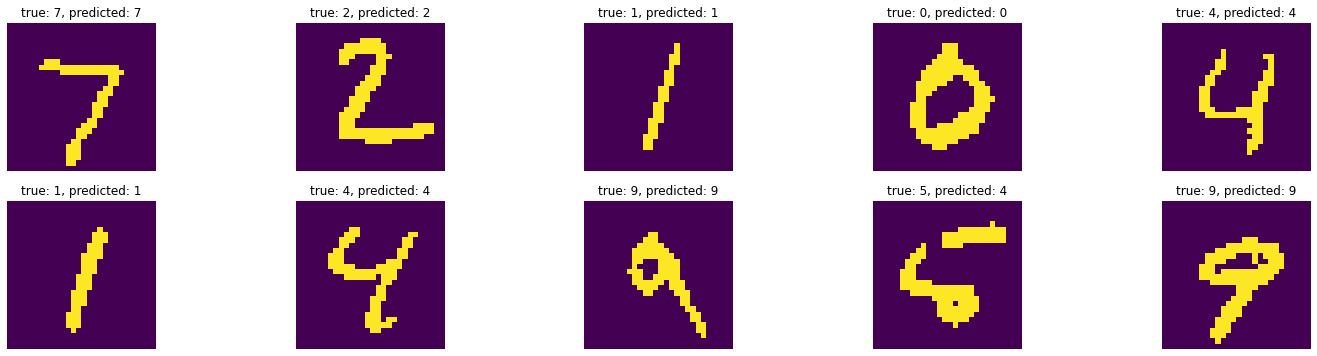

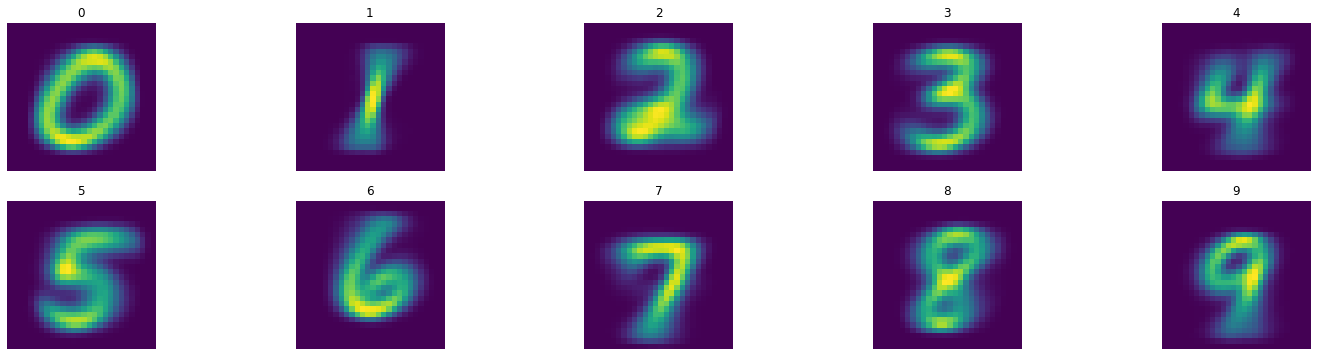

accuracy: 0.8441


In [624]:
train_and_show(NaiveBayes_Cat_MAP(2, 10, cat_prior=0, class_prior=0), bin_train, bin_test)

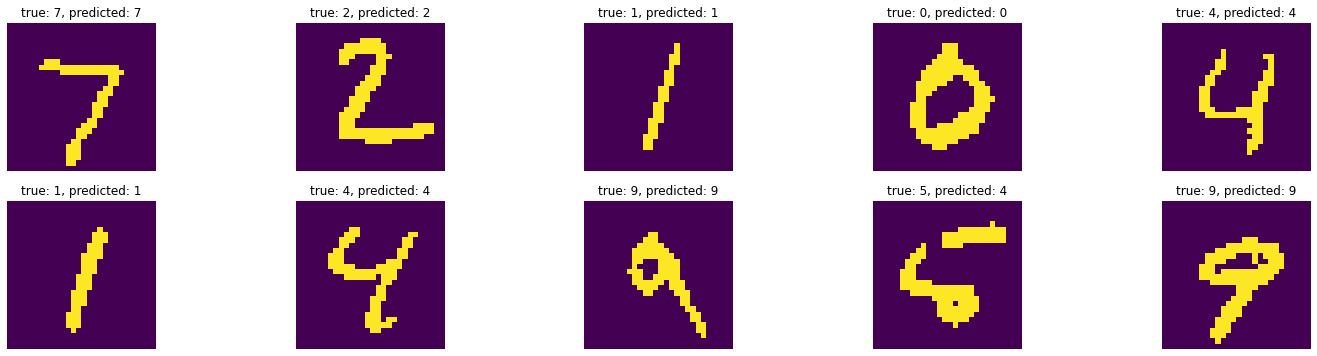

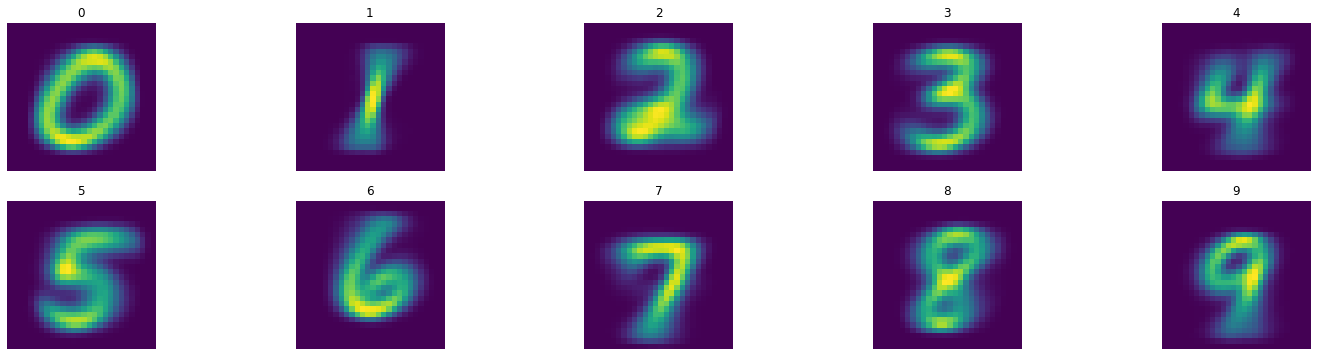

accuracy: 0.8427


In [625]:
train_and_show(NaiveBayes_Cat_MAP(2, 10), bin_train, bin_test)

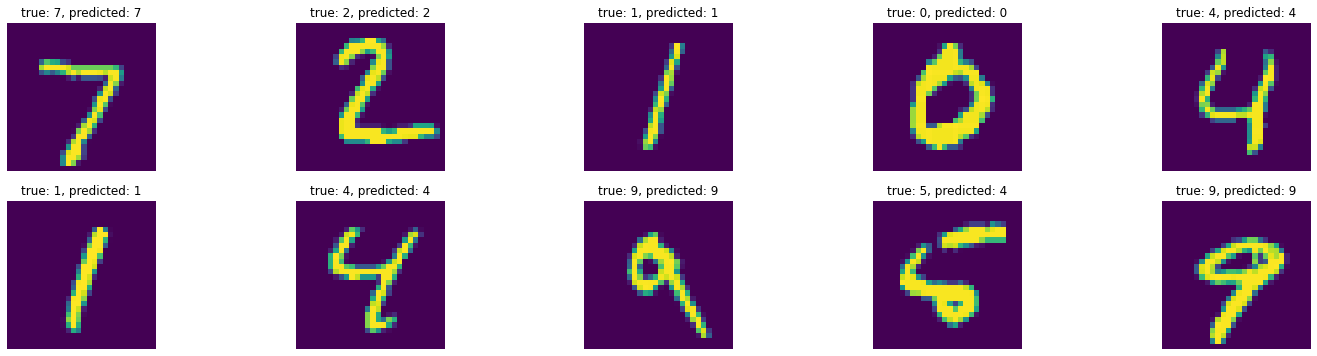

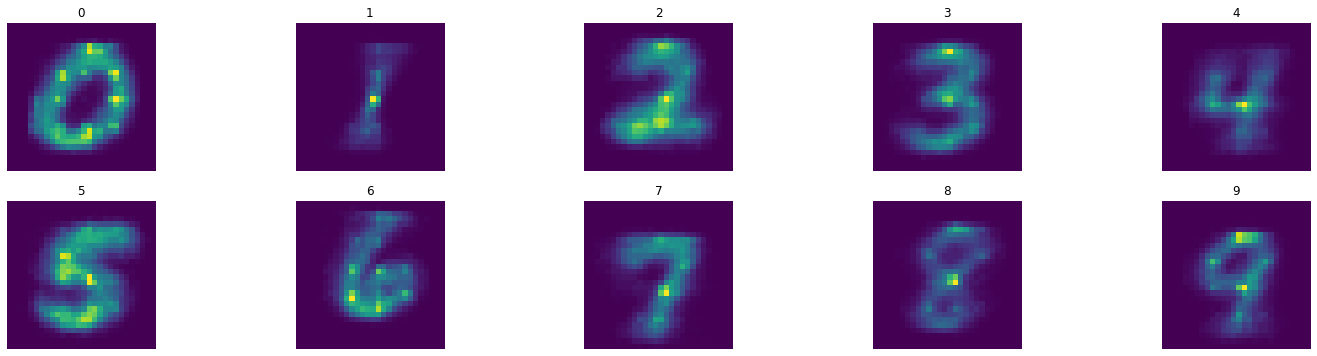

accuracy: 0.8363


In [626]:
train_and_show(NaiveBayes_Cat_MAP(256, 10), train_dataset, test_dataset)

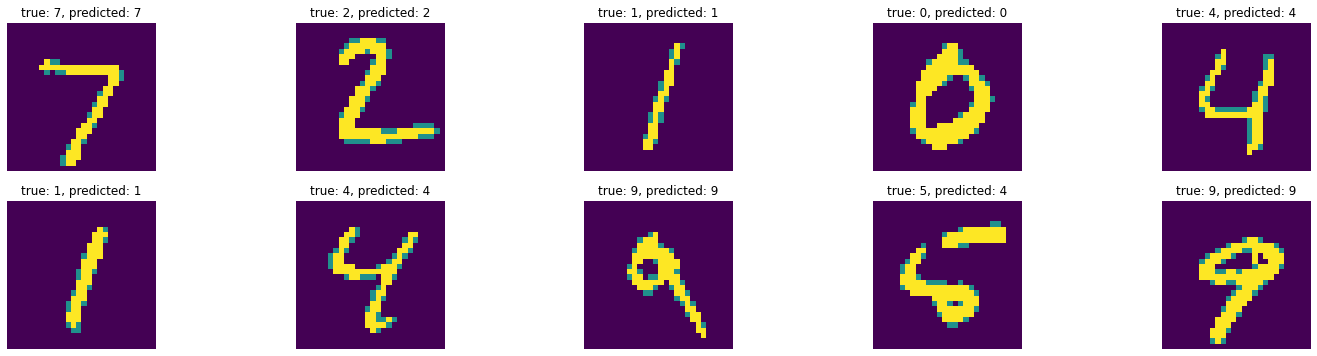

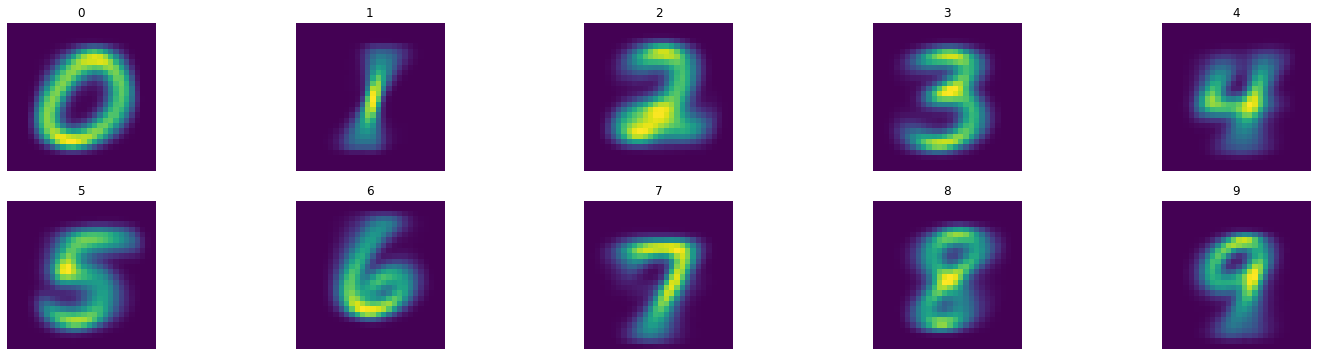

accuracy: 0.8458


In [627]:
cats = 3
train_and_show(NaiveBayes_Cat_MAP(cats, 10), categorize(train_dataset, cats), categorize(test_dataset, cats))